# Sales Data Time Series Analysis - United States

- This is a research based on SuperStore sales data for about 4 years. I am to understand the market trends, and predict future purchases based on the past observed trends in sales.
- I am open to any critism, open an issue on GitHub and ping me so we can exchange ideas and brainstorm on the better approaches to **Time Series Predictions**
- Experiment ARIMA, SARIMA and LSTM models to see which will work best for predicting the `Product` and `Sales Value`.
- It is important to notice that predicting this two features may expose the model to unrequired complexity, however, let me share my short notes for my earlier research for what approach to take:

## Short Notes
- Approach will involve multi-output predictions which we intend to predict both the product and the quantity. 
- Predicting both will result to two separate models: **classification model(products)** and **regression model(quantity)**.
- Well, this sounds easy in theory, implementation may have a challenge: it requires a two step architecture which has a Shared Encoder(by the product and qty) and a Separate Heads(One for the product, another for the qty)

## Tool-kits That Are Supported to approach (Product & Qty)
- Pytorch Lightning
- Hugging  Face Transformers with `TimeSeriesTransformer`
- GluonTS/Darts for Time series Forecasting
- Sktime for classic approach

## Trends to take into consideration
- Lastsale made/ Ship Date
- Customer Name
- Sales Value

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
from IPython.display import display

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
# TODO: Loading the dataset
data_path = os.path.join("../data", "train.csv")
data = pd.read_csv(data_path)

data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [3]:
# TODO: Visualize the data statistical overview
print("Statistical Overview:")
display(data.describe())

print("\nDataset Information:")
data.info()

print("\nMissing Values:")
display(data.isna().sum())

Statistical Overview:


,Row ID,Postal Code,Sales
count,9800.000000,9789.000000,9800.000000
mean,4900.500000,55273.322403,230.769059
std,2829.160653,32041.223413,626.651875
min,1.000000,1040.000000,0.444000
25%,2450.750000,23223.000000,17.248000
50%,4900.500000,58103.000000,54.490000
75%,7350.250000,90008.000000,210.605000
max,9800.000000,99301.000000,22638.480000



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null  

Row ID            0
Order ID          0
Order Date        0
Ship Date         0
Ship Mode         0
Customer ID       0
Customer Name     0
Segment           0
Country           0
City              0
State             0
Postal Code      11
Region            0
Product ID        0
Category          0
Sub-Category      0
Product Name      0
Sales             0
dtype: int64

In [4]:
# TODO: Sample a few rows from the dataset, random seed for reproducability
data.sample(10, random_state=10)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
4495,4496,CA-2018-112753,18/06/2018,23/06/2018,Standard Class,CC-12670,Craig Carreira,Consumer,United States,Los Angeles,California,90032.0,West,FUR-BO-10004015,Furniture,Bookcases,"Bush Andora Bookcase, Maple/Graphite Gray Finish",917.9235
192,193,CA-2016-102281,12/10/2016,14/10/2016,First Class,MP-17470,Mark Packer,Home Office,United States,New York City,New York,10035.0,East,FUR-BO-10002545,Furniture,Bookcases,"Atlantic Metals Mobile 3-Shelf Bookcases, Cust...",626.3520
9075,9076,US-2016-136259,05/11/2016,08/11/2016,First Class,CB-12415,Christy Brittain,Consumer,United States,Lakewood,Ohio,44107.0,East,OFF-BI-10000773,Office Supplies,Binders,Insertable Tab Post Binder Dividers,7.2180
1523,1524,CA-2016-144806,06/12/2016,11/12/2016,Standard Class,GH-14425,Gary Hwang,Consumer,United States,Tucson,Arizona,85705.0,West,OFF-PA-10003039,Office Supplies,Paper,Xerox 1960,198.2720
2145,2146,US-2017-152051,25/06/2017,29/06/2017,Standard Class,TS-21160,Theresa Swint,Corporate,United States,York,Pennsylvania,17403.0,East,FUR-CH-10002965,Furniture,Chairs,Global Leather Highback Executive Chair with P...,422.0580
5160,5161,CA-2016-156146,26/10/2016,30/10/2016,Second Class,AG-10495,Andrew Gjertsen,Corporate,United States,Peoria,Arizona,85345.0,West,TEC-PH-10001527,Technology,Phones,Plantronics MX500i Earset,68.7200
1645,1646,CA-2016-111829,19/03/2016,20/03/2016,First Class,FH-14365,Fred Hopkins,Corporate,United States,Seattle,Washington,98115.0,West,OFF-PA-10004359,Office Supplies,Paper,Multicolor Computer Printout Paper,209.7000
8077,8078,CA-2016-106187,23/06/2016,29/06/2016,Standard Class,RF-19345,Randy Ferguson,Corporate,United States,East Point,Georgia,30344.0,South,OFF-BI-10004519,Office Supplies,Binders,GBC DocuBind P100 Manual Binding Machine,165.9800
8094,8095,CA-2018-133046,27/07/2018,01/08/2018,Second Class,DK-13375,Dennis Kane,Consumer,United States,Seattle,Washington,98115.0,West,OFF-PA-10003883,Office Supplies,Paper,"Message Book, Phone, Wirebound Standard Line M...",26.2000
5439,5440,CA-2017-167115,04/04/2017,09/04/2017,Standard Class,EH-14185,Evan Henry,Consumer,United States,New York City,New York,10035.0,East,OFF-BI-10004600,Office Supplies,Binders,Ibico Ibimaster 300 Manual Binding System,588.7840


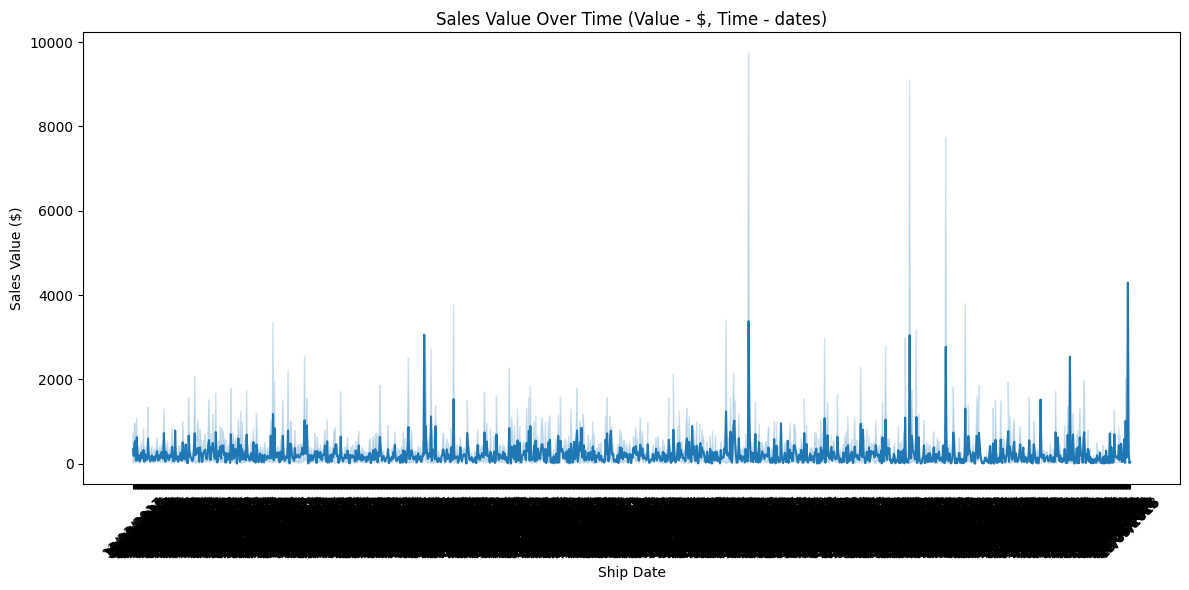

In [5]:
# TODO: Visualize the sales volume over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x="Ship Date", y="Sales")
plt.title("Sales Value Over Time (Value - $, Time - dates)")
plt.xlabel("Ship Date")
plt.ylabel("Sales Value ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

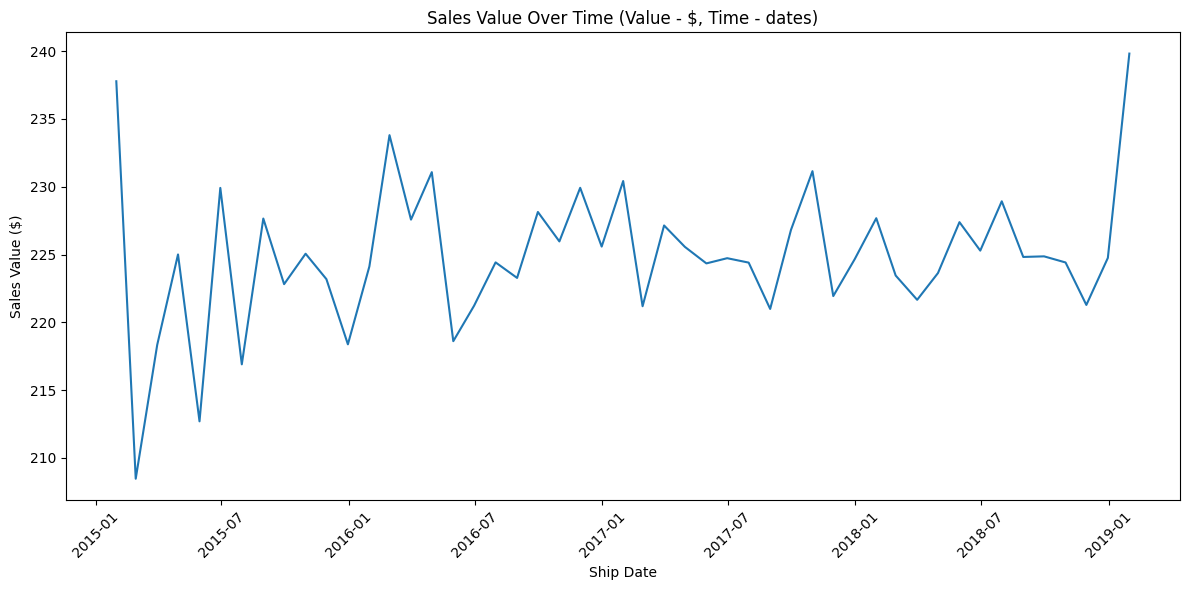

In [6]:
# TODO: Smooth using Exponential Moving Average(EMA)

data["Ship Date"] = pd.to_datetime(data["Ship Date"], dayfirst=True)
data.sort_index(ascending=False, inplace=True)
data.set_index('Ship Date', inplace=True)
data["ema_sales"] = data["Sales"].ewm(span=500, adjust=False).mean()
data_monthly = data[["Sales", "ema_sales"]].resample("M").mean()
data_monthly.reset_index(inplace=True)

plt.figure(figsize=(12, 6))
sns.lineplot(data=data_monthly, x="Ship Date", y="ema_sales")
plt.title("Sales Value Over Time (Value - $, Time - dates)")
plt.xlabel("Ship Date")
plt.ylabel("Sales Value ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

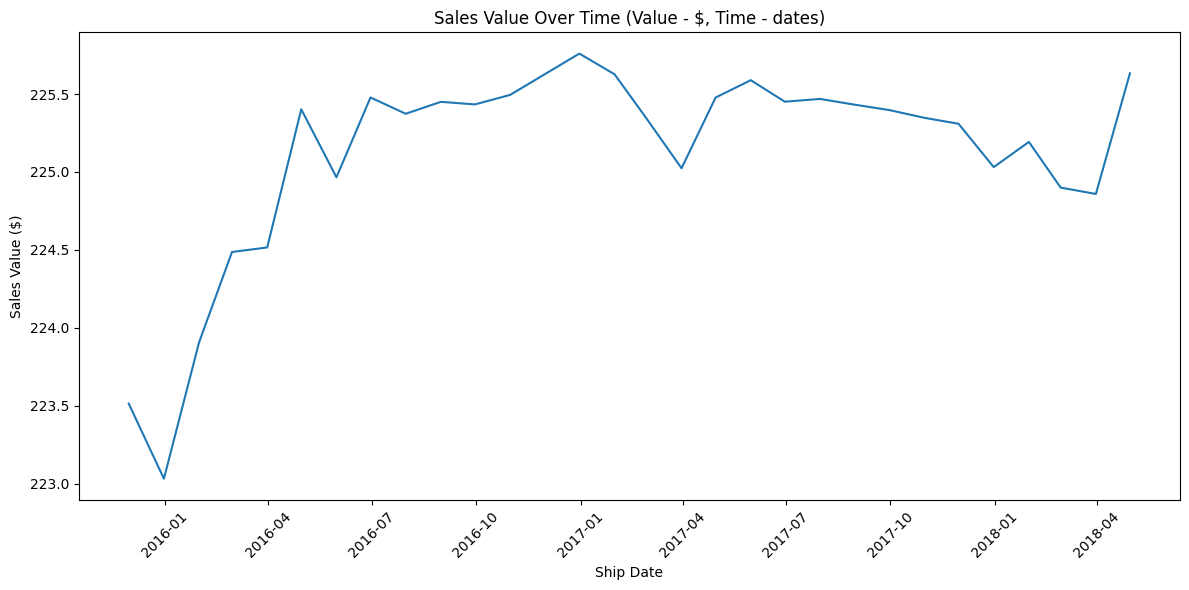

In [7]:
data_monthly["ema_sales_smoothed"] = data_monthly["ema_sales"].rolling(window=20, center=True).mean()

plt.figure(figsize=(12, 6))
sns.lineplot(data=data_monthly, x="Ship Date", y="ema_sales_smoothed")
plt.title("Sales Value Over Time (Value - $, Time - dates)")
plt.xlabel("Ship Date")
plt.ylabel("Sales Value ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
data.head()

,Row ID,Order ID,Order Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,ema_sales
Ship Date,,,,,,,,,,,,,,,,,,
2016-01-17,9800,CA-2016-128608,12/01/2016,Standard Class,CS-12490,Cindy Schnelling,Corporate,United States,Toledo,Ohio,43615.0,East,TEC-AC-10000487,Technology,Accessories,SanDisk Cruzer 4 GB USB Flash Drive,10.384,10.384000
2016-01-17,9799,CA-2016-128608,12/01/2016,Standard Class,CS-12490,Cindy Schnelling,Corporate,United States,Toledo,Ohio,43615.0,East,TEC-PH-10000912,Technology,Phones,Anker 24W Portable Micro USB Car Charger,26.376,10.447840
2016-01-17,9798,CA-2016-128608,12/01/2016,Standard Class,CS-12490,Cindy Schnelling,Corporate,United States,Toledo,Ohio,43615.0,East,TEC-PH-10004977,Technology,Phones,GE 30524EE4,235.188,11.345007
2016-01-17,9797,CA-2016-128608,12/01/2016,Standard Class,CS-12490,Cindy Schnelling,Corporate,United States,Toledo,Ohio,43615.0,East,OFF-AR-10001374,Office Supplies,Art,"BIC Brite Liner Highlighters, Chisel Tip",10.368,11.341106
2017-05-28,9796,CA-2017-125920,21/05/2017,Standard Class,SH-19975,Sally Hughsby,Corporate,United States,Chicago,Illinois,60610.0,Central,OFF-BI-10003429,Office Supplies,Binders,"Cardinal HOLDit! Binder Insert Strips,Extra St...",3.798,11.310994


In [9]:
data.describe()

,Row ID,Postal Code,Sales,ema_sales
count,9800.000000,9789.000000,9800.000000,9800.000000
mean,4900.500000,55273.322403,230.769059,224.678771
std,2829.160653,32041.223413,626.651875,36.319118
min,1.000000,1040.000000,0.444000,10.384000
25%,2450.750000,23223.000000,17.248000,206.206693
50%,4900.500000,58103.000000,54.490000,222.661276
75%,7350.250000,90008.000000,210.605000,242.247275
max,9800.000000,99301.000000,22638.480000,346.426288


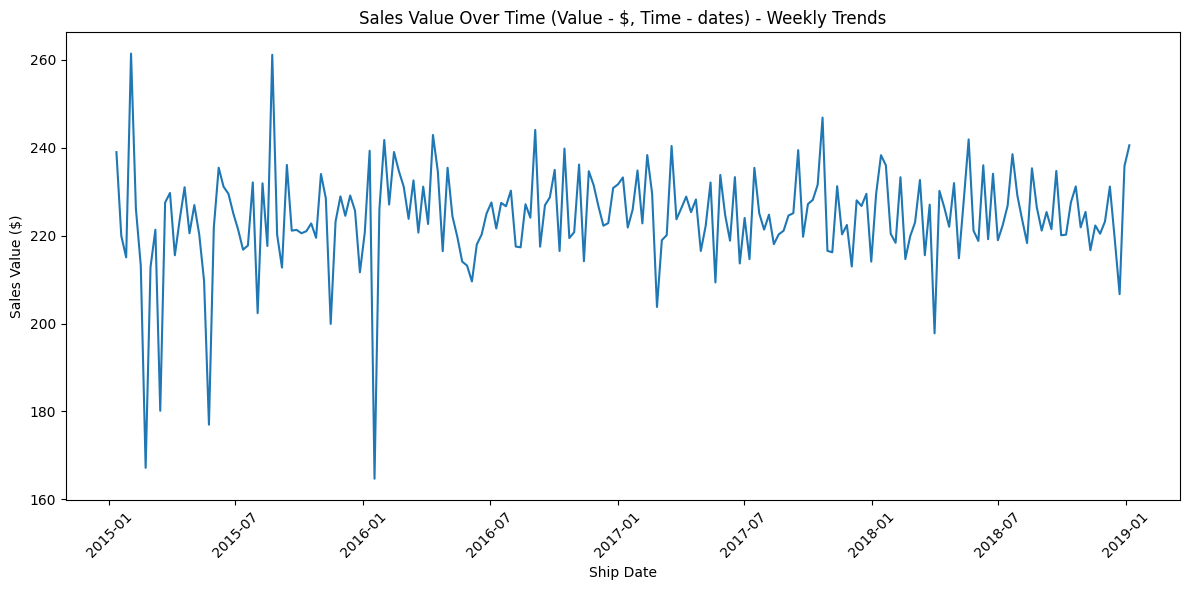

In [10]:
data_weekly = data[["Sales", "ema_sales"]].resample("W").mean()
data_weekly.reset_index(inplace=True)

plt.figure(figsize=(12, 6))
sns.lineplot(data=data_weekly, x="Ship Date", y="ema_sales")
plt.title("Sales Value Over Time (Value - $, Time - dates) - Weekly Trends")
plt.xlabel("Ship Date")
plt.ylabel("Sales Value ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

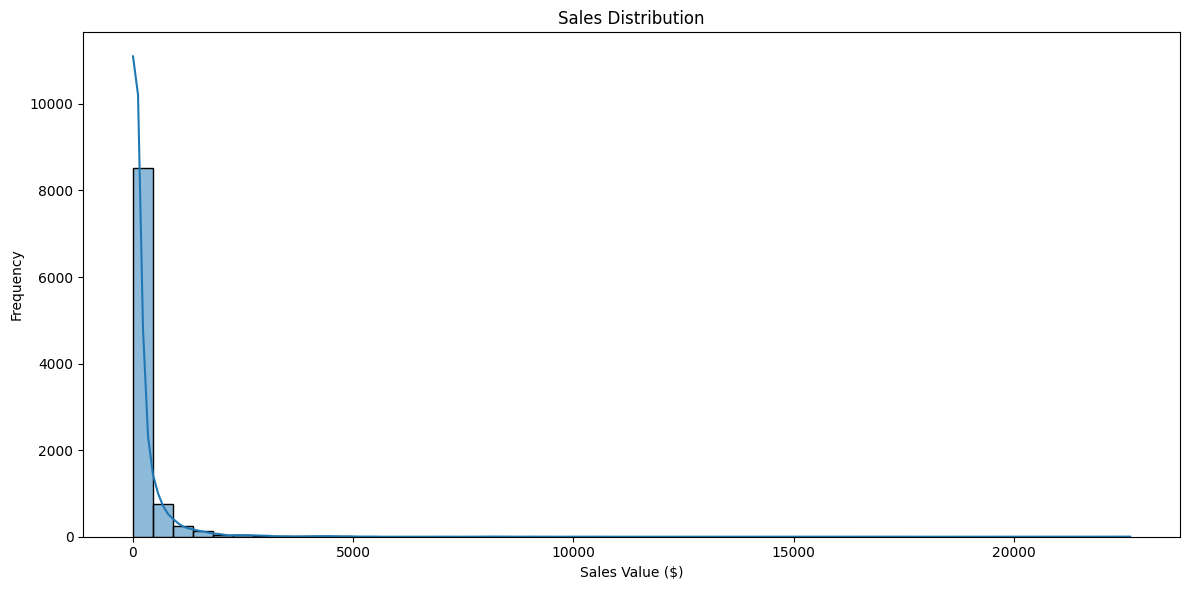

In [11]:
# TODO: Plot the distribution of sales using a histogram
plt.figure(figsize=(12, 6))
sns.histplot(data=data, x="Sales", bins=50, kde=True)
plt.title("Sales Distribution")
plt.xlabel("Sales Value ($)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [12]:
# get the  names of the columns
columns = data.columns
print("Columns in the dataset:", list(columns))

Columns in the dataset: ['Row ID', 'Order ID', 'Order Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Sales', 'ema_sales']


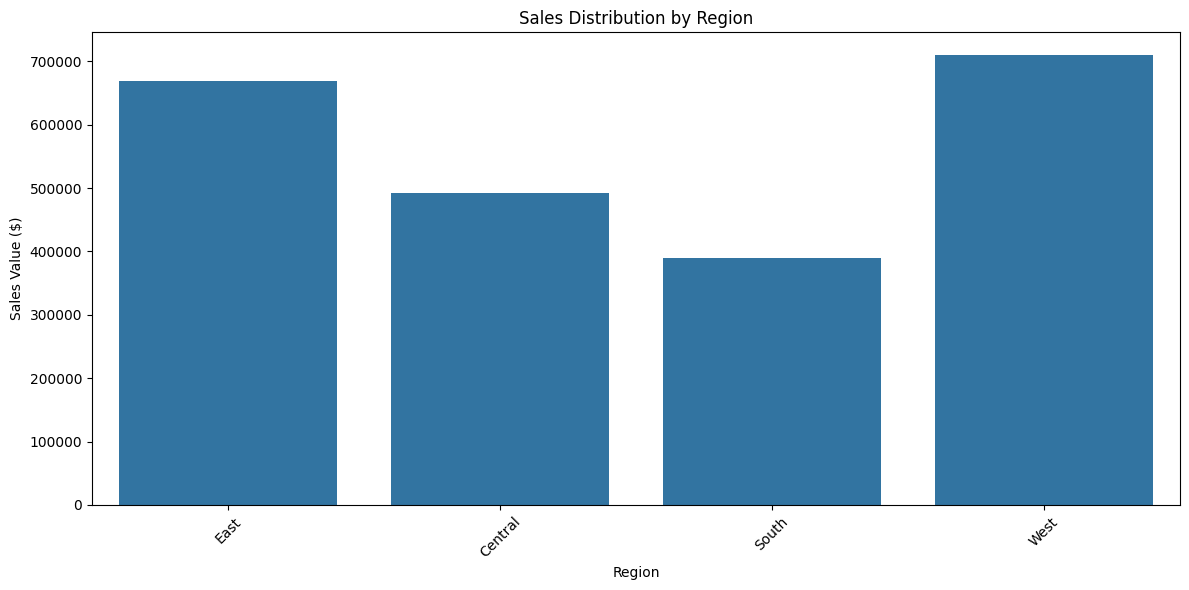

In [13]:
#  TODO: Visualize the distribution of sales by region
plt.figure(figsize=(12, 6))
sns.barplot(data=data, x="Region", y="Sales", estimator=np.sum, ci=None)
plt.title("Sales Distribution by Region")
plt.ylabel("Sales Value ($)")
plt.xlabel("Region")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

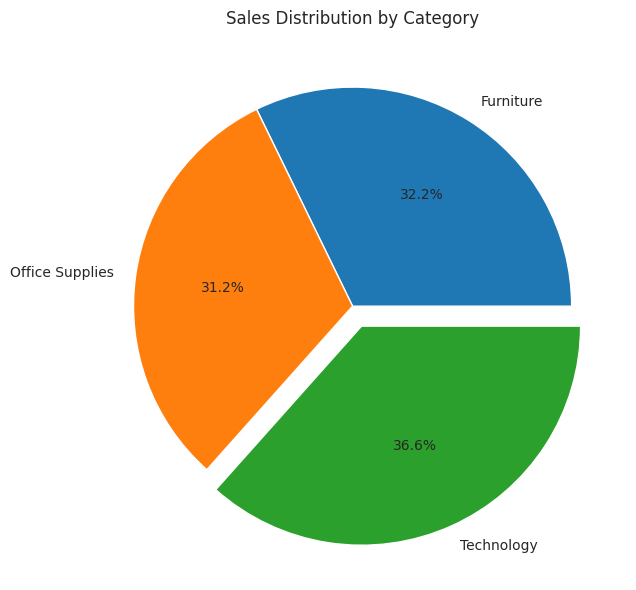

In [14]:
# TODO: Plot sales contribution for individual products
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

# Calculate sales sum by category
category_sales = data.groupby('Category')['Sales'].sum()

# Create pie chart
plt.pie(x=category_sales.values, labels=category_sales.index, autopct='%1.1f%%', explode=[0, 0, 0.1])
plt.title("Sales Distribution by Category")

plt.tight_layout()
plt.show()

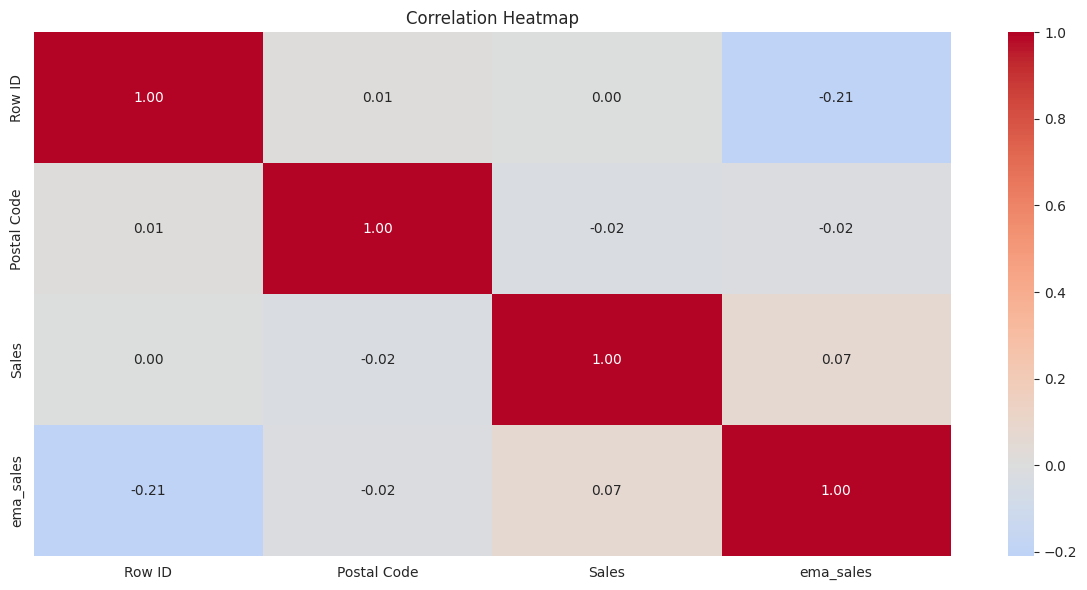

In [15]:
# Visualize the correlation for the numerical columns in the dataset
numerical = data.select_dtypes(include=[np.number])

plt.figure(figsize=(12, 6))
sns.heatmap(numerical.corr(), annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [16]:
# TODO: Drop the columns that make no significant contribution to the analysis
data.drop(columns=["Row ID", "Order ID", "Order Date", "Customer ID", "Product ID", "Postal Code"], inplace=True)

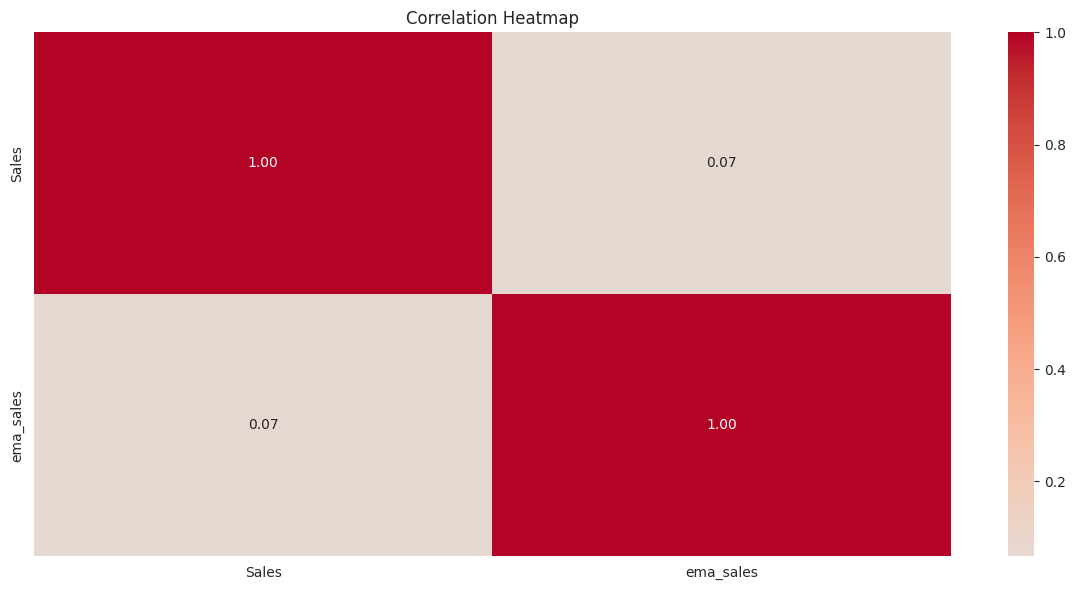

In [17]:
# Visualize the correlation for the numerical columns in the dataset
numerical = data.select_dtypes(include=[np.number])

plt.figure(figsize=(12, 6))
sns.heatmap(numerical.corr(), annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

# NOTE: ema_sales is not required in our case, here's why, I created the feature using the \
# sales column for Exponential Moving Average(EMA) and then used the EMA column to create a \
# smoothed version of the Sales column.

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9800 entries, 2016-01-17 to 2017-11-11
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Ship Mode      9800 non-null   object 
 1   Customer Name  9800 non-null   object 
 2   Segment        9800 non-null   object 
 3   Country        9800 non-null   object 
 4   City           9800 non-null   object 
 5   State          9800 non-null   object 
 6   Region         9800 non-null   object 
 7   Category       9800 non-null   object 
 8   Sub-Category   9800 non-null   object 
 9   Product Name   9800 non-null   object 
 10  Sales          9800 non-null   float64
 11  ema_sales      9800 non-null   float64
dtypes: float64(2), object(10)
memory usage: 995.3+ KB


In [19]:
data.head()

,Ship Mode,Customer Name,Segment,Country,City,State,Region,Category,Sub-Category,Product Name,Sales,ema_sales
Ship Date,,,,,,,,,,,,
2016-01-17,Standard Class,Cindy Schnelling,Corporate,United States,Toledo,Ohio,East,Technology,Accessories,SanDisk Cruzer 4 GB USB Flash Drive,10.384,10.384000
2016-01-17,Standard Class,Cindy Schnelling,Corporate,United States,Toledo,Ohio,East,Technology,Phones,Anker 24W Portable Micro USB Car Charger,26.376,10.447840
2016-01-17,Standard Class,Cindy Schnelling,Corporate,United States,Toledo,Ohio,East,Technology,Phones,GE 30524EE4,235.188,11.345007
2016-01-17,Standard Class,Cindy Schnelling,Corporate,United States,Toledo,Ohio,East,Office Supplies,Art,"BIC Brite Liner Highlighters, Chisel Tip",10.368,11.341106
2017-05-28,Standard Class,Sally Hughsby,Corporate,United States,Chicago,Illinois,Central,Office Supplies,Binders,"Cardinal HOLDit! Binder Insert Strips,Extra St...",3.798,11.310994


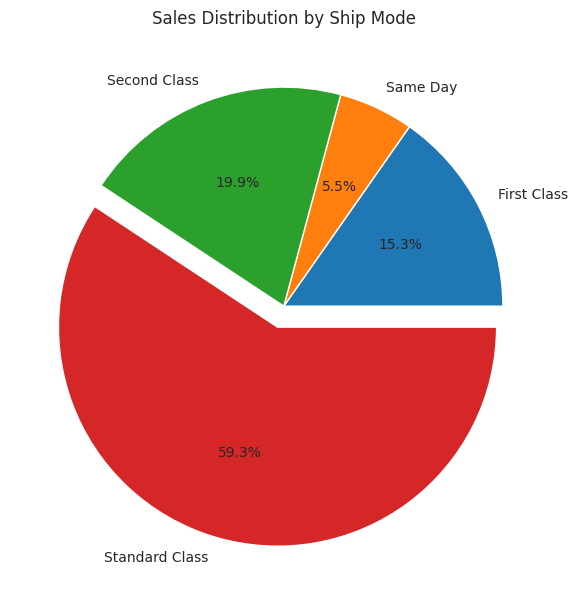

In [20]:
# TODO: Plot for the ship modes and the total sales value for each ship mode category
sales_ship_mode = data.groupby('Ship Mode')['Sales'].sum()

sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
plt.pie(x=sales_ship_mode.values, labels=sales_ship_mode.index, autopct='%1.1f%%', explode=(0, 0, 0, 0.1))
plt.title("Sales Distribution by Ship Mode")
plt.tight_layout()
plt.show()

In [21]:
data.nunique()

Ship Mode           4
Customer Name     793
Segment             3
Country             1
City              529
State              49
Region              4
Category            3
Sub-Category       17
Product Name     1849
Sales            5757
ema_sales        9800
dtype: int64

In [22]:
data["Segment"].unique()

array(['Corporate', 'Consumer', 'Home Office'], dtype=object)

In [23]:
# As of now, we can tell that Country is not a significant feature for our analysis \
# and we can drop it. The same goes for the Segment column, as it has only 3 unique values. \ 
# We can drop it as well. The same goes for Region, Category and Ship Mode columns.
data.drop(columns=["Country", "Segment", "Region", "Category", "Ship Mode", "ema_sales"], inplace=True)
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9800 entries, 2016-01-17 to 2017-11-11
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Customer Name  9800 non-null   object 
 1   City           9800 non-null   object 
 2   State          9800 non-null   object 
 3   Sub-Category   9800 non-null   object 
 4   Product Name   9800 non-null   object 
 5   Sales          9800 non-null   float64
dtypes: float64(1), object(5)
memory usage: 535.9+ KB


,Customer Name,City,State,Sub-Category,Product Name,Sales
Ship Date,,,,,,
2016-01-17,Cindy Schnelling,Toledo,Ohio,Accessories,SanDisk Cruzer 4 GB USB Flash Drive,10.384
2016-01-17,Cindy Schnelling,Toledo,Ohio,Phones,Anker 24W Portable Micro USB Car Charger,26.376
2016-01-17,Cindy Schnelling,Toledo,Ohio,Phones,GE 30524EE4,235.188
2016-01-17,Cindy Schnelling,Toledo,Ohio,Art,"BIC Brite Liner Highlighters, Chisel Tip",10.368
2017-05-28,Sally Hughsby,Chicago,Illinois,Binders,"Cardinal HOLDit! Binder Insert Strips,Extra St...",3.798


In [24]:
data.index

DatetimeIndex(['2016-01-17', '2016-01-17', '2016-01-17', '2016-01-17',
               '2017-05-28', '2015-05-23', '2015-05-23', '2015-05-23',
               '2015-05-23', '2018-04-01',
               ...
               '2015-06-14', '2015-06-14', '2015-06-14', '2015-06-14',
               '2015-06-14', '2016-10-18', '2016-10-18', '2017-06-16',
               '2017-11-11', '2017-11-11'],
              dtype='datetime64[ns]', name='Ship Date', length=9800, freq=None)

In [25]:
# TODO: Including DOW, Month, Year, Weekend and Quarter as features
data["dayofweek"] = data.index.dayofweek
data["month"] = data.index.month
data["Year"] = data.index.year
data["is_weekend"] = np.where(data.index.dayofweek >= 5, 1, 0)
data["quarter"] = data.index.quarter
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9800 entries, 2016-01-17 to 2017-11-11
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Customer Name  9800 non-null   object 
 1   City           9800 non-null   object 
 2   State          9800 non-null   object 
 3   Sub-Category   9800 non-null   object 
 4   Product Name   9800 non-null   object 
 5   Sales          9800 non-null   float64
 6   dayofweek      9800 non-null   int32  
 7   month          9800 non-null   int32  
 8   Year           9800 non-null   int32  
 9   is_weekend     9800 non-null   int64  
 10  quarter        9800 non-null   int32  
dtypes: float64(1), int32(4), int64(1), object(5)
memory usage: 765.6+ KB


,Customer Name,City,State,Sub-Category,Product Name,Sales,dayofweek,month,Year,is_weekend,quarter
Ship Date,,,,,,,,,,,
2016-01-17,Cindy Schnelling,Toledo,Ohio,Accessories,SanDisk Cruzer 4 GB USB Flash Drive,10.384,6,1,2016,1,1
2016-01-17,Cindy Schnelling,Toledo,Ohio,Phones,Anker 24W Portable Micro USB Car Charger,26.376,6,1,2016,1,1
2016-01-17,Cindy Schnelling,Toledo,Ohio,Phones,GE 30524EE4,235.188,6,1,2016,1,1
2016-01-17,Cindy Schnelling,Toledo,Ohio,Art,"BIC Brite Liner Highlighters, Chisel Tip",10.368,6,1,2016,1,1
2017-05-28,Sally Hughsby,Chicago,Illinois,Binders,"Cardinal HOLDit! Binder Insert Strips,Extra St...",3.798,6,5,2017,1,2


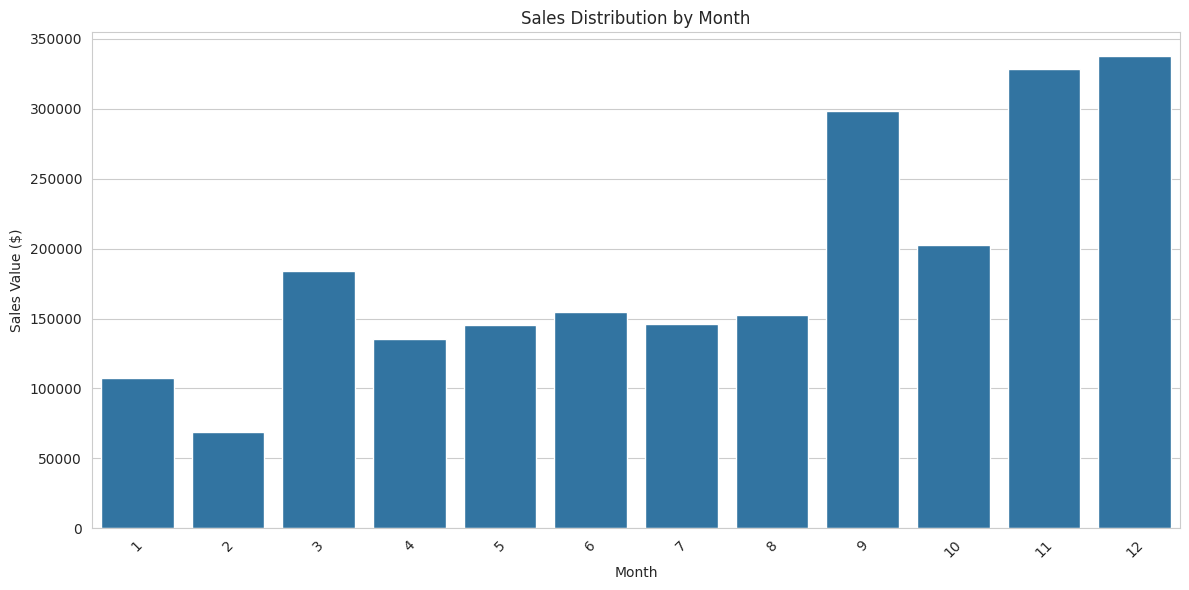

In [26]:
# TODO: Visualize sales by month
plt.figure(figsize=(12, 6))
sns.barplot(data=data, x="month", y="Sales", estimator=np.sum, ci=None)
plt.title("Sales Distribution by Month")
plt.ylabel("Sales Value ($)")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

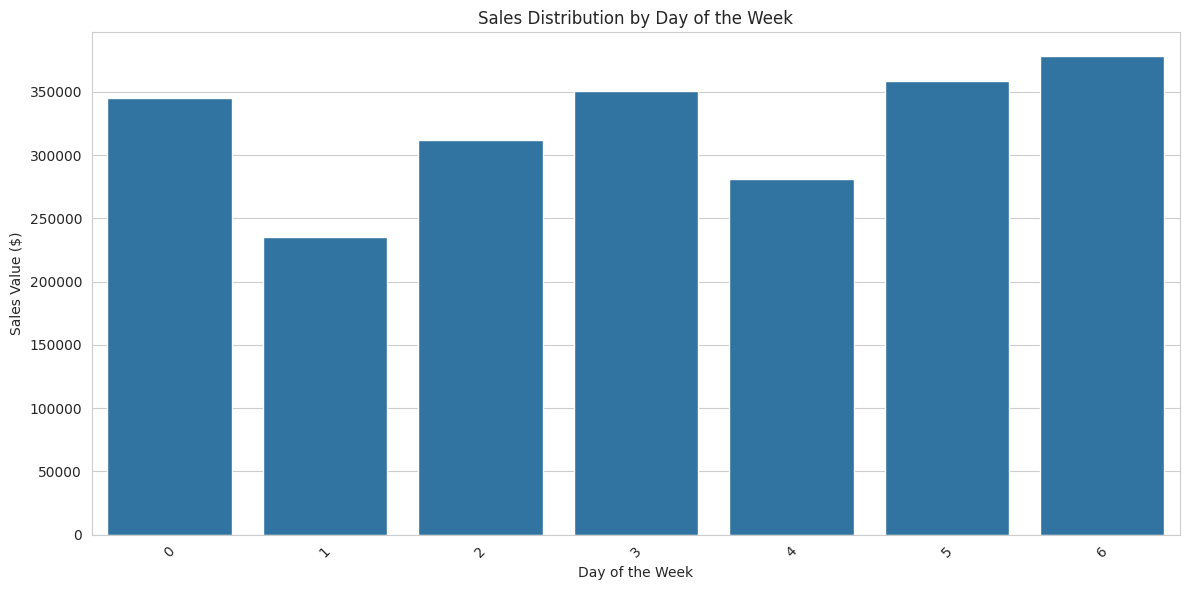

In [27]:
# TODO: Plot the distribution of sales by the day of the week
# NOTE: 0 = Monday, 1 = Tuesday, 2 = Wednesday, 3 = Thursday, 4 = Friday, 5 = Saturday, 6 = Sunday
plt.figure(figsize=(12, 6))
sns.barplot(data=data, x="dayofweek", y="Sales", estimator=np.sum, ci=None)
plt.title("Sales Distribution by Day of the Week")
plt.ylabel("Sales Value ($)")
plt.xlabel("Day of the Week")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from typing import Dict, Tuple

# TODO: Function for label Encoding the categorical columns
def encode_categorical_column(df: pd.DataFrame, column: str) -> Tuple[pd.DataFrame, Dict[str, int]]:
    """This function creates encoding for  a categorical column and returns the new df and a dictionary
    with the mapping of the categorical column to the new values.
    """
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    return df, mapping


# TODO: Create cyclic features for the year, quarter, month and day of the week
def create_cyclic_features(df: pd.DataFrame, column: str) -> pd.DataFrame:
    """This function creates cyclic features for time columns"""
    df[column + "_sin"] = np.sin(2 * np.pi * df[column] / df[column].max())
    df[column + "_cos"] = np.cos(2 * np.pi * df[column] / df[column].max())
    return df


categorical_cols = ["Customer Name", "City", "State", "Sub-Category", "Product Name"]
labels = []

for col in categorical_cols:
    data, mapping = encode_categorical_column(data, col)
    labels.append(mapping)

# Create cyclic features for the month and day of the week
for col in ["month", "dayofweek", "Year", "quarter"]:
    data = create_cyclic_features(data, col)
    print(f"Created cyclic features for {col}")

Created cyclic features for month
Created cyclic features for dayofweek
Created cyclic features for Year
Created cyclic features for quarter


In [29]:
data.head()

,Customer Name,City,State,Sub-Category,Product Name,Sales,dayofweek,month,Year,is_weekend,quarter,month_sin,month_cos,dayofweek_sin,dayofweek_cos,Year_sin,Year_cos,quarter_sin,quarter_cos
Ship Date,,,,,,,,,,,,,,,,,,,
2016-01-17,164,483,33,0,1399,10.384,6,1,2016,1,1,0.5,0.866025,-2.449294e-16,1.0,-0.009336,0.999956,1.000000e+00,6.123234e-17
2016-01-17,164,483,33,13,148,26.376,6,1,2016,1,1,0.5,0.866025,-2.449294e-16,1.0,-0.009336,0.999956,1.000000e+00,6.123234e-17
2016-01-17,164,483,33,13,724,235.188,6,1,2016,1,1,0.5,0.866025,-2.449294e-16,1.0,-0.009336,0.999956,1.000000e+00,6.123234e-17
2016-01-17,164,483,33,2,277,10.368,6,1,2016,1,1,0.5,0.866025,-2.449294e-16,1.0,-0.009336,0.999956,1.000000e+00,6.123234e-17
2017-05-28,663,80,11,3,408,3.798,6,5,2017,1,2,0.5,-0.866025,-2.449294e-16,1.0,-0.006224,0.999981,1.224647e-16,-1.000000e+00


In [30]:
# TODO: Standardize Sales Column
scaler = StandardScaler()
data["Sales"] = scaler.fit_transform(data[["Sales"]])
data.head()

,Customer Name,City,State,Sub-Category,Product Name,Sales,dayofweek,month,Year,is_weekend,quarter,month_sin,month_cos,dayofweek_sin,dayofweek_cos,Year_sin,Year_cos,quarter_sin,quarter_cos
Ship Date,,,,,,,,,,,,,,,,,,,
2016-01-17,164,483,33,0,1399,-0.351705,6,1,2016,1,1,0.5,0.866025,-2.449294e-16,1.0,-0.009336,0.999956,1.000000e+00,6.123234e-17
2016-01-17,164,483,33,13,148,-0.326183,6,1,2016,1,1,0.5,0.866025,-2.449294e-16,1.0,-0.009336,0.999956,1.000000e+00,6.123234e-17
2016-01-17,164,483,33,13,724,0.007052,6,1,2016,1,1,0.5,0.866025,-2.449294e-16,1.0,-0.009336,0.999956,1.000000e+00,6.123234e-17
2016-01-17,164,483,33,2,277,-0.351730,6,1,2016,1,1,0.5,0.866025,-2.449294e-16,1.0,-0.009336,0.999956,1.000000e+00,6.123234e-17
2017-05-28,663,80,11,3,408,-0.362215,6,5,2017,1,2,0.5,-0.866025,-2.449294e-16,1.0,-0.006224,0.999981,1.224647e-16,-1.000000e+00


In [31]:
data = data.drop(columns=["dayofweek", "month", "Year", "quarter"])
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9800 entries, 2016-01-17 to 2017-11-11
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Customer Name  9800 non-null   int64  
 1   City           9800 non-null   int64  
 2   State          9800 non-null   int64  
 3   Sub-Category   9800 non-null   int64  
 4   Product Name   9800 non-null   int64  
 5   Sales          9800 non-null   float64
 6   is_weekend     9800 non-null   int64  
 7   month_sin      9800 non-null   float64
 8   month_cos      9800 non-null   float64
 9   dayofweek_sin  9800 non-null   float64
 10  dayofweek_cos  9800 non-null   float64
 11  Year_sin       9800 non-null   float64
 12  Year_cos       9800 non-null   float64
 13  quarter_sin    9800 non-null   float64
 14  quarter_cos    9800 non-null   float64
dtypes: float64(9), int64(6)
memory usage: 1.2 MB


,Customer Name,City,State,Sub-Category,Product Name,Sales,is_weekend,month_sin,month_cos,dayofweek_sin,dayofweek_cos,Year_sin,Year_cos,quarter_sin,quarter_cos
Ship Date,,,,,,,,,,,,,,,
2016-01-17,164,483,33,0,1399,-0.351705,1,0.5,0.866025,-2.449294e-16,1.0,-0.009336,0.999956,1.000000e+00,6.123234e-17
2016-01-17,164,483,33,13,148,-0.326183,1,0.5,0.866025,-2.449294e-16,1.0,-0.009336,0.999956,1.000000e+00,6.123234e-17
2016-01-17,164,483,33,13,724,0.007052,1,0.5,0.866025,-2.449294e-16,1.0,-0.009336,0.999956,1.000000e+00,6.123234e-17
2016-01-17,164,483,33,2,277,-0.351730,1,0.5,0.866025,-2.449294e-16,1.0,-0.009336,0.999956,1.000000e+00,6.123234e-17
2017-05-28,663,80,11,3,408,-0.362215,1,0.5,-0.866025,-2.449294e-16,1.0,-0.006224,0.999981,1.224647e-16,-1.000000e+00


In [32]:
# TODO: Create a Random Forest Regressor, GradientBBoosting Regressor and Lasso Model for Feature Selection
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso

X, y = data.drop(columns=["Sales"]), data["Sales"]

models = {
    'rf': RandomForestRegressor(n_estimators=100, random_state=42),
    'gb': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'lasso': Lasso(alpha=0.01, random_state=42)
}

importance_df = pd.DataFrame(index=X.columns)

for name, model in models.items():
    model.fit(X, y)
    if hasattr(model, 'coef_'):
        importance_df[name] = abs(model.coef_)
    else:
        importance_df[name] = model.feature_importances_

# Normalize and rank
importance_df = importance_df.rank(ascending=False)
importance_df['avg_rank'] = importance_df.mean(axis=1)
top_features = importance_df.sort_values('avg_rank').head(15)

In [33]:
print(top_features)

# NOTE: The lower the average rank, the more consistently valuable the feature is across different modeling paradigms.
# TODO: Select features below an average rank of 7

threshold = 7
features_to_select = top_features[top_features['avg_rank'] <= threshold].index
selected_features = X[list(features_to_select)]

                 rf    gb  lasso   avg_rank
Sub-Category    2.0   2.0    2.0   2.000000
Product Name    1.0   1.0    6.0   2.666667
dayofweek_cos   7.0   4.0    1.0   4.000000
Customer Name   3.0   3.0    7.0   4.333333
State           5.0   5.0    5.0   5.000000
City            4.0   7.0    8.0   6.333333
month_cos       8.0   8.0    4.0   6.666667
month_sin       6.0   6.0   11.5   7.833333
quarter_cos    11.0  14.0    3.0   9.333333
Year_sin       10.0  11.0   11.5  10.833333
dayofweek_sin   9.0  12.0   11.5  10.833333
is_weekend     14.0   9.0   11.5  11.500000
Year_cos       13.0  10.0   11.5  11.500000
quarter_sin    12.0  13.0   11.5  12.166667


### Feature Importance & Selection Analysis Report

I have reviewed the feature importance rankings from Random Forest, Gradient Boosting, and Lasso. Here are my key observations and thoughts:

- **High-Performing Features**:  
    I found that **Sub-Category** and **Product Name** are consistently ranked among the most important features across all models. They seem to have strong predictive power, so I plan to retain them in the model. Depending on their cardinality, I might explore target encoding to simplify their representation.

- **Moderate Features & Potential Overfitting Risks**:  
    **Customer Name** appears moderately important in tree-based methods but is penalized by Lasso. This discrepancy suggests that, while it could be informative, it might also be causing overfitting. I will consider encoding methods (like target encoding) or possibly dropping it if it doesn't add value. Similar caution applies to features like **City** and **State**.

- **Cyclic Features**:  
    The cyclic features I engineered (`dayofweek_sin`, `dayofweek_cos`, `month_sin`, `month_cos`, etc.) show mixed importance. In particular, `dayofweek_cos` stands out as more relevant. I might combine or even drop some of the less promising cyclic components such as `quarter_cos`, `Year_cos`, and `is_weekend` to reduce redundancy without losing crucial temporal information.

- **Next Steps**:  
    1. **Feature Pruning**: Remove features with low importance such as some of the cyclic components and consider dropping `Customer Name` if further tests confirm overfitting.  
    2. **Refinement of Encoding Schemes**: Experiment with target encoding for high-cardinality categorical features like **Product Name**, **Customer Name**, **City**, and **State**.  
    3. **Model Reassessment**: After modifying the feature set, I'll run cross-validation to see how these changes affect model performance.

This analysis guides me toward a more streamlined feature set that should help improve model generalization by focusing on features with consistent predictive power.


In [34]:
selected_features.head()

,Sub-Category,Product Name,dayofweek_cos,Customer Name,State,City,month_cos
Ship Date,,,,,,,
2016-01-17,0,1399,1.0,164,33,483,0.866025
2016-01-17,13,148,1.0,164,33,483,0.866025
2016-01-17,13,724,1.0,164,33,483,0.866025
2016-01-17,2,277,1.0,164,33,483,0.866025
2017-05-28,3,408,1.0,663,11,80,-0.866025


In [35]:
len(y)

9800

In [36]:
len(selected_features)

9800

In [37]:
importance_df = pd.DataFrame(index=selected_features.columns)

for name, model in models.items():
    model.fit(selected_features, y)
    if hasattr(model, 'coef_'):
        importance_df[name] = abs(model.coef_)
    else:
        importance_df[name] = model.feature_importances_

# Normalize and rank
importance_df = importance_df.rank(ascending=False)
importance_df['avg_rank'] = importance_df.mean(axis=1)
top_features = importance_df.sort_values('avg_rank').head(15)
print(top_features)

                rf   gb  lasso  avg_rank
Sub-Category   2.0  2.0    2.0  2.000000
Product Name   1.0  1.0    5.0  2.333333
dayofweek_cos  7.0  4.0    1.0  4.000000
Customer Name  3.0  3.0    6.0  4.000000
State          6.0  5.0    4.0  5.000000
month_cos      5.0  7.0    3.0  5.000000
City           4.0  6.0    7.0  5.666667


In [38]:
columns = list(selected_features.columns)
print("Selected Features:", columns)

Selected Features: ['Sub-Category', 'Product Name', 'dayofweek_cos', 'Customer Name', 'State', 'City', 'month_cos']


In [39]:
df = pd.read_csv(data_path)
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [40]:
df.reset_index(inplace=True)
df["Ship Date"] = pd.to_datetime(df["Ship Date"], dayfirst=True)
df.set_index('Ship Date', inplace=True)

df["dayofweek"] = df.index.dayofweek
df["month"] = df.index.month

# TODO: Create cyclic features for the month and day of the week
for col in ["month", "dayofweek"]:
    df = create_cyclic_features(df, col)
    print(f"Created cyclic features for {col}")
df.head()

Created cyclic features for month
Created cyclic features for dayofweek


,index,Row ID,Order ID,Order Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Category,Sub-Category,Product Name,Sales,dayofweek,month,month_sin,month_cos,dayofweek_sin,dayofweek_cos
Ship Date,,,,,,,,,,,,,,,,,,,,,
2017-11-11,0,1,CA-2017-152156,08/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,5,11,-5.000000e-01,0.866025,-0.866025,0.5
2017-11-11,1,2,CA-2017-152156,08/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,5,11,-5.000000e-01,0.866025,-0.866025,0.5
2017-06-16,2,3,CA-2017-138688,12/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,4,6,1.224647e-16,-1.000000,-0.866025,-0.5
2016-10-18,3,4,US-2016-108966,11/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,1,10,-8.660254e-01,0.500000,0.866025,0.5
2016-10-18,4,5,US-2016-108966,11/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,1,10,-8.660254e-01,0.500000,0.866025,0.5


In [41]:
columns.append("Sales")

df = df[columns]
df.head()

,Sub-Category,Product Name,dayofweek_cos,Customer Name,State,City,month_cos,Sales
Ship Date,,,,,,,,
2017-11-11,Bookcases,Bush Somerset Collection Bookcase,0.5,Claire Gute,Kentucky,Henderson,0.866025,261.9600
2017-11-11,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",0.5,Claire Gute,Kentucky,Henderson,0.866025,731.9400
2017-06-16,Labels,Self-Adhesive Address Labels for Typewriters b...,-0.5,Darrin Van Huff,California,Los Angeles,-1.000000,14.6200
2016-10-18,Tables,Bretford CR4500 Series Slim Rectangular Table,0.5,Sean O'Donnell,Florida,Fort Lauderdale,0.500000,957.5775
2016-10-18,Storage,Eldon Fold 'N Roll Cart System,0.5,Sean O'Donnell,Florida,Fort Lauderdale,0.500000,22.3680


In [42]:
# TODO: Create train, validation, and test sets
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42, shuffle=False)

# Split the train data into train and validation sets
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42, shuffle=False)
print(f"Train set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

Train set size: 6272
Validation set size: 1568
Test set size: 1960


In [43]:
# Check for any missing values
print("Missing values in train set:", train_data.isna().sum())
print("Missing values in validation set:", val_data.isna().sum())
print("Missing values in test set:", test_data.isna().sum())

Missing values in train set: Sub-Category     0
Product Name     0
dayofweek_cos    0
Customer Name    0
State            0
City             0
month_cos        0
Sales            0
dtype: int64
Missing values in validation set: Sub-Category     0
Product Name     0
dayofweek_cos    0
Customer Name    0
State            0
City             0
month_cos        0
Sales            0
dtype: int64
Missing values in test set: Sub-Category     0
Product Name     0
dayofweek_cos    0
Customer Name    0
State            0
City             0
month_cos        0
Sales            0
dtype: int64


In [44]:
train_data.to_csv("../data/processed/train_data.csv", index=False)
val_data.to_csv("../data/processed/val_data.csv", index=False)
test_data.to_csv("../data/processed/test_data.csv", index=False)